# Introduction

<table><tr>
<td> <img src="https://leverageedublog.s3.ap-south-1.amazonaws.com/blog/wp-content/uploads/2020/03/24185535/Online-Learning.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://blog.edmentum.com/sites/blog.edmentum.com/files/infographics/Four_Layers_0.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://i0.wp.com/content.edupristine.com/images/blogs/CFA-RESULT-2016.jpg?w=525&ssl=1" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

Improvement in technology has changed how human beings live in the past decades. Technology has improved the living standard of humans, as well as the quality of education in large educational institutions. At UBC, faculty members utilize technology to enhance students’ learning experience, learning websites such as iClicker and Webwork are frequently used by professors and students in order to solidify the knowledge absorbed by students in the lectures. 

The dataset that is used in this project is from https://archive.ics.uci.edu/ml/datasets/User%2BKnowledge%2BModeling.
The dataset records the students' knowledge status about the subject of Electrical DC Machines at Gazi University, Turkey in 2009. Gazi University has developed the user modelling system which keeps track of students’ learning activities on the web learning environment and stores the data in the model. The dataset allows us to observe students’ learning experiences on the online learning platform and exam performance. Then the data are used as input data by a user modelling algorithm aimed at creating a consistent description of the model of students. Eventually, the input data is used to create and update the user knowledge model. The user knowledge model would be used to improve the web learning environment in order to help students learn much better. 

In our project, we would like to utilize the dataset and classify the knowledge level of users (UNS) based on the information provided in the dataset. 

The dataset contains 6 columns and a total of 3 sheets in the excel file (dataset):

STG: degree of study time for goal object materials <br>
SCG: degree of repetition number of user for goal object materials <br>
STR: degree of study time of user for related objects with goal object <br>
LPR: exam performance of user for related objects with goal object <br>
PEG: exam performance of user for goal objects <br>
UNS: the knowledge level of user <br>

Sheet 1 is only the introduction of the dataset, sheet 2 is the training dataset and sheet 3 is the testing dataset. <br>


## Methods & Results
### Overview of our Methodology 
The User Knowledge Modeling dataset has provided us the training dataset and testing dataset already. However, our team decided to combine the two sets of exam performance (LPR & PEG) to create more comprehensive data to better equip our model. Here is an overview of our data analysis methodology (detailed explanation will be presented at each step):

**Reading & Wrangling**: Skipped as the dataset has been split into training dataset and testing dataset already. Overall, the both training and testing datasets are tidy. <br>
<br>

**Train/Test split**: spliting the tidy dataframe into a training set and testing set, then summarizing the sample statistics of the training data.<br>
<br>

**Predictor variables selection**: find the combination of predictors that yield the relatively highest prediction accuracy, by using forward selection. <br>
<br>

**K-Nearest Neighbor classification**: model tuning with cross-validation, reconfigure and re-train the model with the best K parameter, predict the test set for final model accuracy validation.
Results and Conclusion.

### Loading Relevant Libraries

In [1]:
library(tidyverse) # to perform operations on the data set
library(readxl) # To read the dataset into R
library(tidymodels)
library(forcats)
library(RColorBrewer)
library(repr) # to set graph plot size and performing some operations on data set
library(ggplot2)
library(knitr)
options(repr.matrix.max.rows = 6) # limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading and Wrangling our dataset from the web into R
* We downloaded the file from the web using a URL so that it was reproducible and read the data file
* Due to there being several sheets in a single excel file, we read them separately and merged them into a single dataframe called “User_Knowledge”. 
* The dataset in Sheet 1 (**Information**) has only metadata, so we will ignore this sheet.
* The dataset in Sheet 2 (**Training_Data**) has 1 column of metadata and a total of 258 rows. Therefore `select ()` is used as the argument.
* The dataset in Sheet 3 (**Test_Data**) has 1 column of metadata and a total of 145 rows. Therefore `select ()` is used as the argument.
* There was no missing value in any rows.
* The two given datasets have slightly different UNS subcategories, where the **Training_Data** has categories “*High*,” “*Medium*,” “*Low*,” and “*very_low*,” whereas the **Test_Data** has a “*Very Low*” class instead. Therefore, we change every “*very_low*” to “*Very Low*”.
* We combined the rows of both datasets to form one dataset using `rbind()` because in our proposal submission, we used these two sets as given to us by the dataset and later ran into problems in the analysis.
* The UNS column will be our target variable for this analysis. Therefore, it was converted into a factor variable using `as_factor()`.
* The resulting dataset is our wrangled `User_knowledge` dataset with **403** valuable observations.

In [2]:
#Reading the training data set from the Web into R and cleaning it
user_data_training <- download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", destfile = "user_data.xls")
user_data_training <- read_excel("user_data.xls", sheet = 2) # Selecting the "Training_Data"

user_data_training <- select(user_data_training, STG:UNS) #Selecting only the required columns (not including metadata)

user_data_training$UNS[user_data_training$UNS == "very_low"] <- "Very Low" #Setting the "very_low field to Very Low to match with Test_Data"

noquote("Table 1.1")
user_data_training


New names:
• `` -> `...7`
• `` -> `...8`


[1] Table 1.1

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [3]:
#Reading the testing data set from the Web into R and cleaning it
user_data_test <- read_excel("user_data.xls", sheet = 3) #selecting the "Test_Data"
user_data_test <- select(user_data_test, STG:UNS) #Selecting only the required columns (not including metadata)

noquote("Table 1.2")
user_data_test

New names:
• `` -> `...7`
• `` -> `...8`


[1] Table 1.2

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


In [4]:
#Combining both user and test data sets (they have been taken from separate excel sheets)
#robk@statmethods.net, Robert Kabacoff -. “Merging Data.” Quick-R: Merging, www.statmethods.net/management/merging.html.
User_Knowledge <- rbind(user_data_training, user_data_test)|>  #binidng rows in both the data frames using rbind
         mutate(UNS = as_factor(UNS))# mutating UNS column to be of type factor since that column needs to be predicted

noquote("Table 1.3")
User_Knowledge

[1] Table 1.3

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


### Summarizing the Training Data
* Based on our data wrangling step, we have a total of **403** usable observations.
* Thus, we have done a random split of **0.70**, which means 70% of the data is split into the training set and the remaining 30% into the testing set to ensure that we have an adequate amount of observations for training and evaluating the prediction accuracy of our model.
* We also used `set.seed()` for reproducible results as `initial_split()` randomly samples from the dataframe.

In [5]:
set.seed(1) # Use of set.seed to make the split reproducible
User_Knowledge_split <- initial_split(User_Knowledge, prop = 0.7, strata = UNS) #doing the decided 70-30 split of our combined data set
user_knowledge_training <- training(User_Knowledge_split)
user_knowledge_test <- testing(User_Knowledge_split)

* Now we begin exploratory data analysis by summarizing the data into different types of tables.

In [6]:
#Counting the total number of rows in training data set
training_count <- count(user_knowledge_training) 
noquote("Table 1.4")
training_count

#Counting the total number of rows in test data set
test_count <- count(user_knowledge_test) 
noquote("Table 1.5")
test_count

[1] Table 1.4

n
<int>
281


[1] Table 1.5

n
<int>
122


* The tables report that there is **281** observations in **user_knowledge_training** dataset and **122** observations in **user_knowledge_test** dataset

In [7]:
#Counting the total number of observations of each class (training data set) to check for class imbalance (if any)
user_data_summarize <- user_knowledge_training |>
                       group_by(UNS) |>
                       summarize(Number_Of_Observations = n())

noquote("Table 1.6")
user_data_summarize

[1] Table 1.6

UNS,Number_Of_Observations
<fct>,<int>
Very Low,35
High,71
Low,90
Middle,85


* The table (Table 1.6) reports the number of observations in each class.
* Using `group_by(UNS)`, we grouped our table by the UNS variable and then applied `n()` to count the number of observations in each class.
* It is observed that there are fewer cases of *"Very Low"* as compared to the other classes in our training dataset, but there is no need to over-sample the data.


In [8]:
# Using map_df to calculate mean of each of our predictor variables and return the result as a dataframe
user_data_mean <- select(user_knowledge_training, STG:PEG) |>
                  map_df(mean)

noquote("Table 1.7")
user_data_mean

[1] Table 1.7

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3460427,0.3679537,0.4660676,0.4365516,0.4583737


* The table (Table 1.7) reports the means of the predictor variables.
* Here, we select all the predictor variables and apply `map_df` to apply `mean()` to each of the columns to obtain the mean statistic for each variable.
* The table does not suggest that any specific predictor needs more attention.

In [9]:
# Using map_df to calculate mean of each of our predictor variables for each class and return the result as a dataframe

verylow_avg_pred_vals <- user_knowledge_training |> # Mean values of predictors for Very Low UNS
    filter(UNS == "Very Low") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c(" Very Low"))
noquote("Table 1.8")
verylow_avg_pred_vals 
    
low_avg_pred_vals <- user_knowledge_training |>  # Mean values of predictors for UNS of Low UNS
    filter(UNS == "Low") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c("Low"))
noquote("Table 1.9")
low_avg_pred_vals

middle_avg_pred_vals <- user_knowledge_training |> # Mean values of predictors for UNS of Middle UNS
    filter(UNS == "Middle") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c(" Middle"))
noquote("Table 1.10")
middle_avg_pred_vals

high_avg_pred_vals <- user_knowledge_training |> # Mean values of predictors for UNS of High UNS
    filter(UNS == "High") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c("High"))
noquote("Table 1.11")
high_avg_pred_vals

[1] Table 1.8

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.2428,0.274,0.3417143,0.2903143,0.09714286,Very Low


[1] Table 1.9

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.3194,0.3257667,0.4515556,0.4451111,0.2571444,Low


[1] Table 1.10

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.3612118,0.3835294,0.5049412,0.3923529,0.528,Middle


[1] Table 1.11

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.4125493,0.4490986,0.4992254,0.5507042,0.808169,High


* Tables above (Table 1.8 - Table 1.11) report the means of the predictor variables for each knowledge level.
* The following tables help us to compare the summary statistics for each knowledge level.
* It is observed that the mean value of **LPR** in Low is higher than that in Middle. Otherwise, no apparent issues in these statistics between the four classes that suggest we need to conduct further analysis to distinguish the significant predictors.


### Predictor variables selection 


* We begin our data analysis by tuning our classifier to choose which variables from our data will be treated as predictor variables. 
* Next, we want to determine if any irrelevant predictors in our data set will negatively impact our classifier.
* To ensure that the choice of which variables to include as predictors is part of tuning our classifier, we conduct this on our **training set**.
* We will use the forward selection method to find the best predictors.

In forward selection, we need to
1. start with a model having no predictors
2. run the following three steps until you run out of predictors:

    A.  for each unused predictor, add it to the model to form a candidate model
    
    B. tune all of the candidate models
    
    C. update the model to be the candidate model with the highest cross-validation accuracy
3. select the model that provides the best trade-off between accuracy and simplicity
    
    

**We will be selecting the 2 best predictors according to this method in our code so that it runs relatively faster than the code for 5 predictors.**

In [10]:
set.seed(1) # Used to make the predictors selection reproducible


uk_subset1 <- user_knowledge_training |> select(STG,SCG,STR,LPR,PEG,UNS )
names1 <- colnames(uk_subset1 |> select(-UNS))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
uk_vfold <- vfold_cv(uk_subset1, v = 5, strata = UNS)

# store the total number of predictors
n_total <- length(names1)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names1)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names1[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        uk_recipe <- recipe(as.formula(model_string), data = uk_subset1) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(uk_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = uk_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names1[[jstar]])
    names1 <- names1[-jstar]
}

noquote("Table 1.12")
accuracies

[1] Table 1.12

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8470551
2,UNS ~ PEG+LPR,0.9501880
3,UNS ~ PEG+LPR+STR,0.9431704
4,UNS ~ PEG+LPR+STR+STG,0.8897243
5,UNS ~ PEG+LPR+STR+STG+SCG,0.8327068


* The table (Table 1.12) represents the models' respective accuracies for **ALL** predictor variables.
* As meaningful predictors are added, the estimated accuracy increases substantially, whereas adding irrelevant variables causes the accuracy to either exhibit small fluctuations or decrease as the model attempts to tune the number of neighbors to account for the extra noise.
* Naturally, we balance high accuracy with simplicity. Keeping this in mind, we find the best model by observing the point where the accuracy stops increasing dramatically and levels off or begins to decrease. Therefore, we chose **LPR** and **PEG** as our predictors since the accuracy decreases as we add more predictors to the model.

### Tuning our K-NN classifier

* We now conduct the K-NN classification analysis on our  dataset with predictors: **LPR** and **PEG**
* To do this, we:
1. create a recipe with the predictors:**LPR** and **PEG**, specifying the data to be **user_knowledge_training**. Additionally, we did not center or scale our predictors since they were all already in the range of 0.0 to 1.0. When scaling is performed, the value/meaning behind the data is lost. So we decided that not scaling this data would be best.
2. Define the specification for our k-nn model. We use `tune()` for the neighbours' argument because we will first tune our model to choose the best k-value for our model.
3. Perform cross-validation with 5 folds. This is because our dataset is not too large, so 20% of the data for validation is considerably accurate.
4. Create a workflow adding the recipe and the model and applying the `tune_grid()` function for cross-validation. We then collect the resulting accuracies with the `collect_metrics()` function.
5. Finally, we plot the accuracies against the neighbors to visualize the most stable k nearest neighbor.

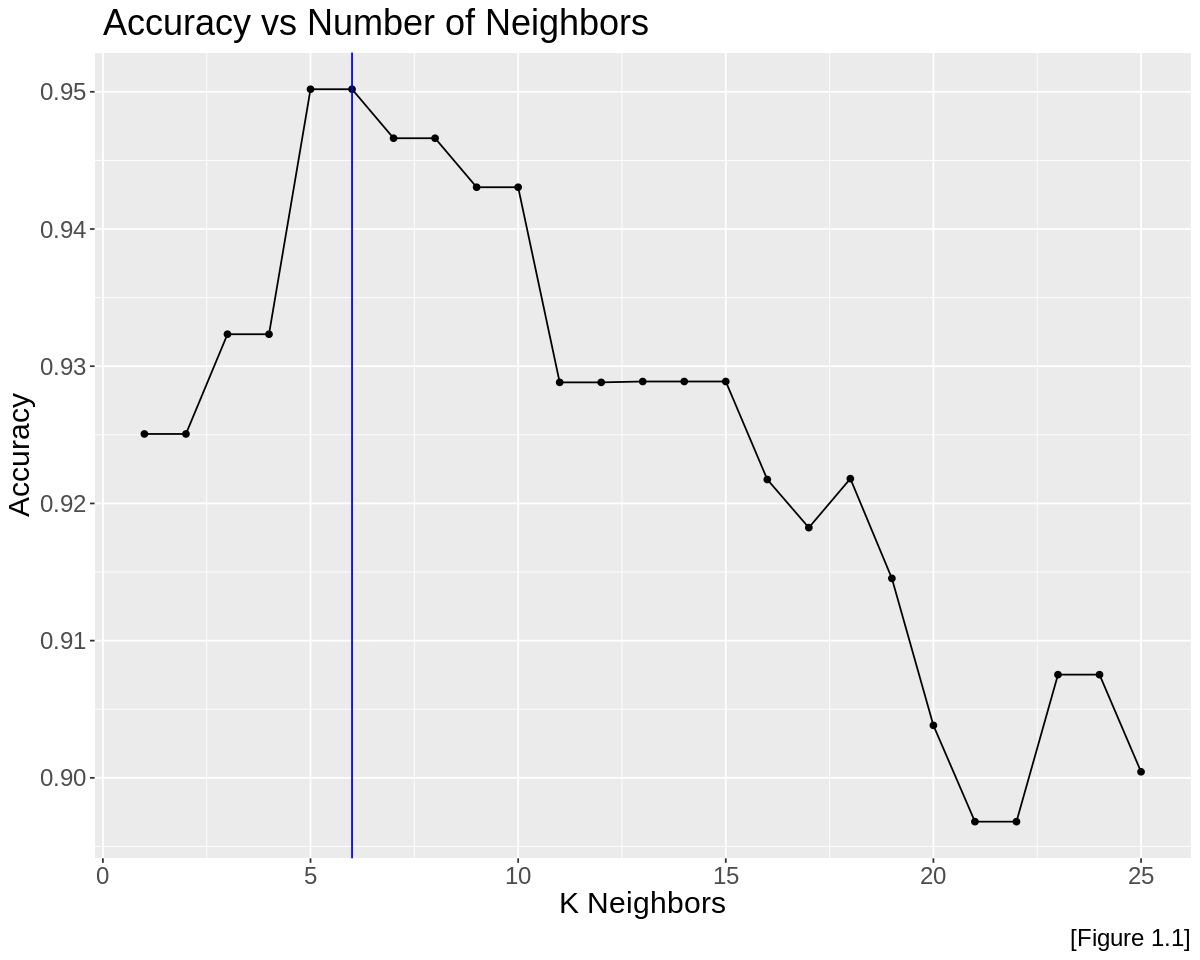

In [11]:
set.seed (1) 
options(repr.plot.height = 8, repr.plot.width = 10)

#Making the recipe with our predictor variables (LPR and PEG)
user_recipe <- recipe(UNS ~ LPR + PEG , user_knowledge_training)
               

#Making the model using "straight-line" distance between points
#We keep the number of neighbors as tune() in order to get the optimised k value usign cross-validation
user_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")

#We use 5 folds for cross-validation as we beilieve that it would not require a lot of time
user_vfold <- vfold_cv(user_knowledge_training, v = 5, strata = UNS)

#We test 25 values of k
klots <-  tibble(neighbors = seq(from = 1, to = 25, by = 1))

#We put it all together in a workflow
user_metrics <- workflow() |>
                add_recipe(user_recipe) |> #adding the recipe
                add_model(user_model) |> #adding the model
                tune_grid(resamples = user_vfold, grid = klots) |> #using tune_grid as we use cross-validation
                collect_metrics() #collecting the metrics of our cross validation

#Using the metric fucntion to find the accuracy of our classifier
user_accuracy <- user_metrics |> 
                 filter(.metric == "accuracy") #Filtering the column by "accuracy"

#Plotting the k values (number of neighbors) and the corresponding accuracy to get an optimized k value
cross_val_plot <- ggplot(user_accuracy, aes(x = neighbors, y = mean)) + 
                  geom_point() +
                  geom_line() +
                  geom_vline(xintercept = 6, colour = "blue")+
                  labs(x = "K Neighbors", y = "Accuracy", caption = "[Figure 1.1]") +
                  ggtitle(" Accuracy vs Number of Neighbors") +
                  theme(text = element_text(size = 18))

cross_val_plot


# This visualization suggests that K=6 provides the highest and the most omptimal accuracy.

* The above graph (Figure 1.1) demonstrates that **k = 6** is the most optimal value. This is because it is relatively higher than most other neighbors and does not immediately fall as we increase or decrease the neighbor by 1

###  The K-NN Classification model

* Now, we use the number of neighbors as 6 to build our model and keep the recipe as before, as we still want to use the same two predictors. 
* We put it together in a workflow and then fit it into our **training dataset**.

In [12]:
#Now that we know that k = 6 has the highest probability of being the highest accuracy classifier, we can make the model
user_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
             set_engine("kknn") |>
             set_mode("classification")

user_fit <-  workflow() |>
             add_recipe(user_recipe) |> #adding the recipe to the workflow
             add_model(user_spec) |> #adding the model to the workflow
             fit(data = user_knowledge_training) #fitting the workflow to our training data

user_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05338078
Best kernel: rectangular
Best k: 6

### Testing the accuracy of our K-NN classification model

* Now, we conduct our K-NN classification on the **testing set** with the help of our trained model.
* We  use the `predict` function to predict the classes of the **testing set** and `bind_cols` to join the UNS class of the testing set to our predicted column to compare the two.


In [13]:
#Now that we have the model set up, we can predict the UNS class
user_predictions <- predict(user_fit, user_knowledge_test) |> 
                     bind_cols(user_knowledge_test) #adding the test data columns to our predicted column in order to see our classifier accuracy

#We use the metrics functions on the table which contains the predicted column along with the actual column to see our classsifier accuracy
user_metrics <- user_predictions |>
                metrics(truth = UNS, estimate = .pred_class) |>
                filter(.metric == "accuracy")

noquote("Table 1.13")
user_metrics

[1] Table 1.13

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9918033


* It is observed in the table above (Table 1.13) that the accuracy of our predictions was extremely high at 99.2%.

 * To further analyse the classifier accuracy, we used `conf_mat` to make a confusion matrix. It helped us to see which observations had been predicted wrong and what were the correct classes of those observations.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



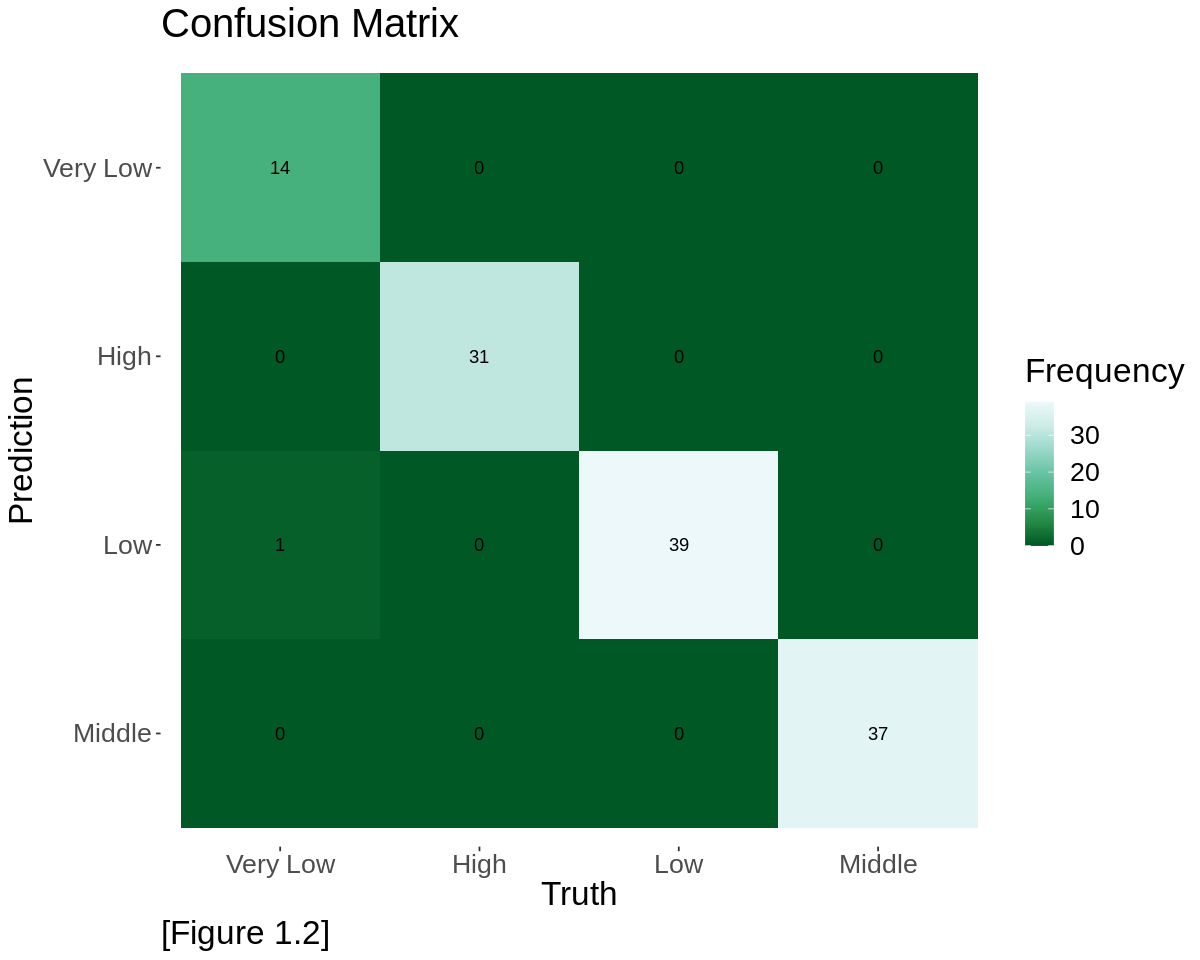

In [14]:
#We make a confusion matrix to see which classes in particular have been predicted incorrectly and whether we can afford these errors (false negatives and/or postitives) or not
user_conf <- user_predictions |>
             conf_mat(truth = UNS, estimate = .pred_class)


autoplot(user_conf, type = "heatmap") +
    scale_fill_distiller(palette = "BuGn", name = "Frequency") + #color blind friendly
    labs(title = "Confusion Matrix", caption = "[Figure 1.2]") +
    theme(legend.position = "right", text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0)) 



* The confusion matrix (Figure 1.2) shows that our classifier’s only wrong prediction was not terrible because the classifier predicted *“Low”* when the actual value was *‘Very Low’*, which is just one class level up.

* Finally, we make an interference plot to visualize our classifier's accuracy by shading the graph's area with the color of the predicted class and coloring the data points with their correct category. This way, we can visually see which data points lie in the accurate shaded color (predicted correctly) and which do not (mispredicted).

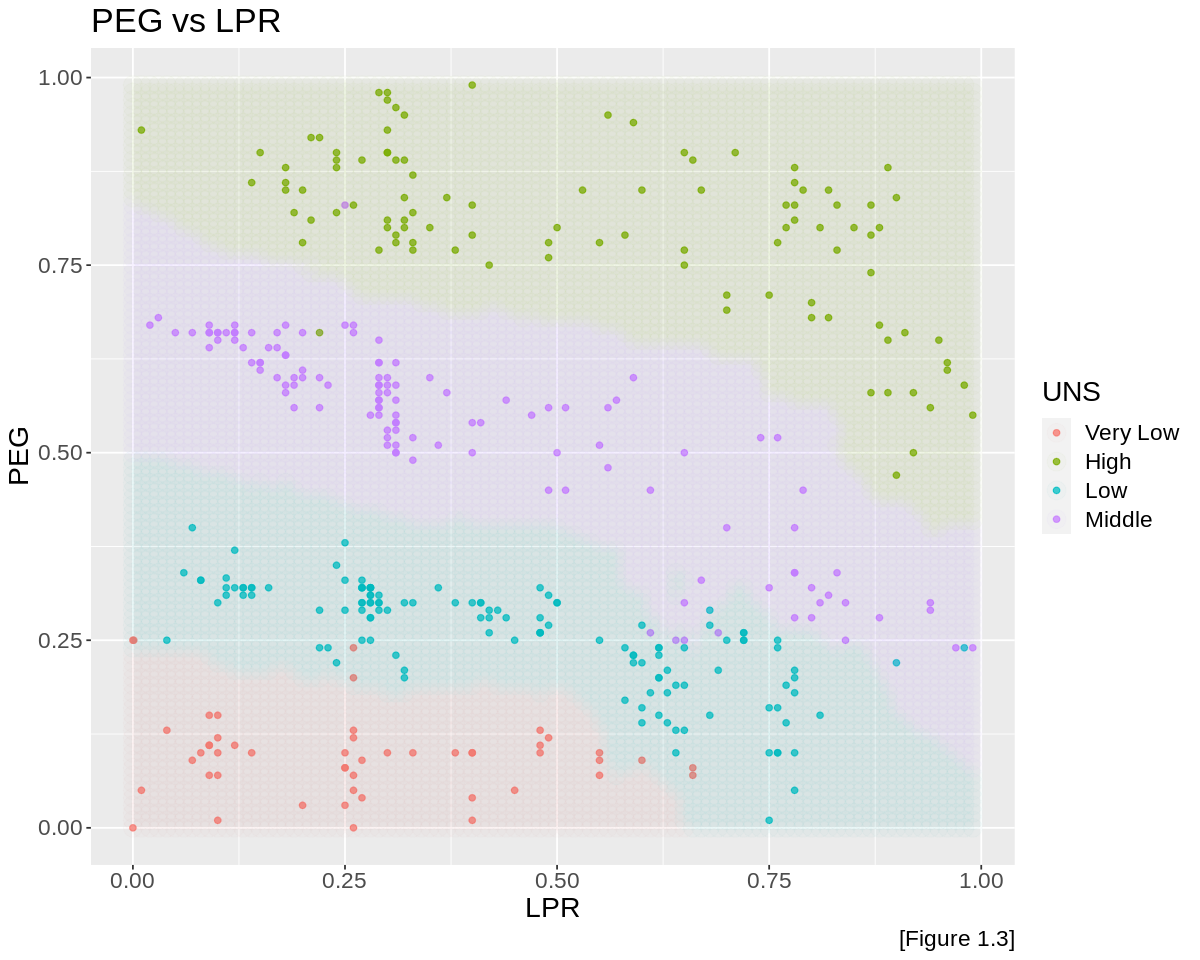

In [15]:
#Making a final plot of our classsifer which colours our classifier predictions by area

# create the grid of LPR/PEG vals, and arrange in a data frame
are_grid <- seq(min(User_Knowledge$LPR), 
                max(User_Knowledge$LPR), 
                length.out = 100)
smo_grid <- seq(min(User_Knowledge$PEG), 
                max(User_Knowledge$PEG), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(LPR = are_grid, 
                                PEG = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(user_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
                    rename(Class = .pred_class)

#making the decided plot
plot <- ggplot() +
              geom_point(data = User_Knowledge, 
              mapping = aes(x = LPR, 
                            y = PEG,
                            color = UNS), 
              alpha = 0.75) +
              geom_point(data = prediction_table, 
              mapping = aes(x = LPR, 
                            y = PEG,
                            color = Class), 
              alpha = 0.02, 
              size = 5) +
              labs(color = "UNS", 
              x = "LPR", 
              y = "PEG",
              caption = "[Figure 1.3]") +
              ggtitle("PEG vs LPR") +
              theme(text = element_text(size = 17))

plot

* From the plot (Figure 1.3), we observe that there are barely a few points that lie outside their right color (the correct predicted color) which further emphasizes the excellent quality of our classifier. We also observe that as the values of both our predictor variables increases, the level of UNS class also increases (*Very Low* < *Low* < *Middle* < *High*)

## Discussion ##

In this classification, we only used 2 predictors (LPR & PEG). As evident through our analysis above, our classifier accuracy is 99.2%. The significantly high accuracy has proved that our selection of predictors is correct. From the confusion matrix (Figure 1.2), we only got 1 prediction wrong. Overall, the matrix does not show significant false positives or negatives at all. Thus, we believe that the accuracy of our classifier is accurate to make any future predictions. <br>
<br>
The final plot (Figure 1.3) visualizes all the predictions and it shows the positive relationship between exam performance (LPR & PEG)  and user knowledge level (UNS). This matches our expectations as we believe that the better the exam performance of students, the higher the overall knowledge. In conclusion, better exam performance almost always correlates with higher knowledge level of students in the course. <br>
<br>
On the other hand, we believe that the findings can contribute to the research area of education. In the future, researchers can further improve the quality of teaching and student learning experience by designing better study habits for students based on the conclusions of the findings. <br>
<br>
Some future questions this could lead to is:

1. Whether students have a better learning experience by studying/ majoring in 2 related/ similar areas (e.g., Computer Science and Physics or English Literature and History) simultaneously.

2. Does repetition study method help students achieve a higher knowledge level in the subjects? If so, what is the best number of times for students to study the exact same material in a week in order to achieve the best exam result. 


**Reference**

1. UCI Machine Learning Repository: Data Sets. (n.d.). Retrieved December 1, 2022, from https://archive.ics.uci.edu/ml/datasets/User%2BKnowledge%2BModeling

2. 1. H. T. Kahraman, Sagiroglu, S., Colak, I., Developing intuitive knowledge classifier and modeling of users' domain dependent data in web, Knowledge Based Systems, vol. 37, pp. 283-295, 2013.